<a href="https://colab.research.google.com/github/Murarin8877/Deep-Generative-Model/blob/main/HW9_LLM_Finetune_Emotion_Risk_%E5%BB%96%E7%BF%8A%E8%87%BB_%E5%BC%B5%E6%99%AF%E9%99%BD_%E8%91%89%E8%AA%8C%E9%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#colab中文設定

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-11-09 04:47:30--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.68.101, 74.125.68.138, 74.125.68.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-11-09 04:47:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   114MB/s    in 0.2s    

2025-11-09 04:47:33 (11

#資料切分和測試個案設定

In [ ]:
# ====================================================
# HW9 - LLM Finetune for Emotion & Depression Risk
# ====================================================

!pip install datasets transformers peft evaluate accelerate bitsandbytes matplotlib seaborn -q

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ====================================================
# 1️⃣ Dataset Loading
# ====================================================
dataset = load_dataset("dair-ai/emotion")

# 標籤對照
emotion_labels = dataset["train"].features["label"].names
print("Emotion labels:", emotion_labels)

# ====================================================
# 2️⃣ Emotion → Depression Risk Mapping（for dataset）
# ====================================================
def map_risk_dataset(example):
    mapping = {
        "joy": 0, "love": 0, "surprise": 0,
        "anger": 1, "fear": 1,
        "sadness": 2
    }
    emotion = emotion_labels[example["label"]]
    example["risk_label"] = mapping[emotion]
    return example

dataset = dataset.map(map_risk_dataset)
print(dataset["train"][0])

# ====================================================
# 共用函式：Emotion → Risk（for model outputs）
# ====================================================
def map_risk_from_emotion(emotion: str):
    """
    將模型輸出的情緒字串轉換為風險標籤
    回傳 (risk_code, risk_label)
    """
    emotion = emotion.lower()
    if emotion in ["joy", "love", "surprise"]:
        return 0, "low_risk"
    elif emotion in ["anger", "fear"]:
        return 1, "mid_risk"
    elif emotion in ["sadness", "depression"]:
        return 2, "high_risk"
    else:
        return -1, "unknown"
# ====================================================
# 3️⃣ 從資料集擷取測試句子
# ====================================================
import random

# 固定隨機種子，確保結果可重現
random.seed(42)

# 從 test split 中各類別各取一個樣本
sample_texts = []
for label_id, label_name in enumerate(emotion_labels):
    examples = [x for x in dataset["test"] if x["label"] == label_id]
    ex = random.choice(examples)
    sample_texts.append({"text": ex["text"], "true_emotion": label_name})

print("\n📘 測試樣本（從 dataset 抽取）:")
for s in sample_texts:
    print(f"- {s['text']} ({s['true_emotion']})")

Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': 'i didnt feel humiliated', 'label': 0, 'risk_label': 2}

📘 測試樣本（從 dataset 抽取）:
- i sit here writing this i feel unhappy inside (sadness)
- i feel privileged in my world (joy)
- i feel are loyal especially after all ive experienced recently but i can trust him (love)
- i didnt start feeling the excitement until the movie was almost over and then it started coming in violent waves (anger)
- i didn t feel pressured or constrained in my choices to behave in a particular way i just felt very busy (fear)
- i am feeling overwhelmed by trying to do it all that i think on the women before me (surprise)


#Zero-shot

In [ ]:
# ====================================================
# 4️⃣ Zero-shot Inference (批次結構化輸出版)
# ====================================================
from transformers import pipeline
import re
import json

VALID_EMOTIONS = ["joy", "love", "surprise", "anger", "fear", "sadness"]

def parse_batch_output(output: str, num_tests: int, valid_emotions: list) -> dict:
    """
    解析批次輸出,返回 {test_id: emotion} 字典
    """
    results = {}
    valid_set = set(e.lower() for e in valid_emotions)

    # 策略 1: 尋找 "Test X: emotion" 模式
    pattern = r'Test\s*(\d+)\s*[:\-]?\s*(\w+)'
    matches = re.findall(pattern, output, re.IGNORECASE)

    for test_id, emotion in matches:
        test_num = int(test_id)
        emotion_lower = emotion.lower()
        if test_num <= num_tests and emotion_lower in valid_set:
            results[test_num] = emotion_lower

    # 策略 2: 尋找 "X. emotion" 或 "X) emotion" 模式
    if len(results) < num_tests:
        pattern2 = r'(\d+)[\.)]\s*(\w+)'
        matches2 = re.findall(pattern2, output, re.IGNORECASE)

        for test_id, emotion in matches2:
            test_num = int(test_id)
            emotion_lower = emotion.lower()
            if test_num not in results and test_num <= num_tests and emotion_lower in valid_set:
                results[test_num] = emotion_lower

    # 策略 3: JSON 格式解析
    if len(results) < num_tests:
        try:
            json_match = re.search(r'\{[^{}]*\}', output, re.DOTALL)
            if json_match:
                parsed = json.loads(json_match.group(0))
                for key, value in parsed.items():
                    if 'test' in key.lower():
                        test_num = int(re.search(r'\d+', key).group())
                        if test_num not in results and test_num <= num_tests:
                            emotion_lower = value.lower()
                            if emotion_lower in valid_set:
                                results[test_num] = emotion_lower
        except:
            pass

    # 策略 4: 按順序匹配情緒詞 (回退機制)
    if len(results) < num_tests:
        emotion_matches = re.findall(r'\b(' + '|'.join(valid_emotions) + r')\b',
                                     output, re.IGNORECASE)
        # Zero-shot 沒有範例,直接使用
        for i, emotion in enumerate(emotion_matches[:num_tests], 1):
            if i not in results:
                results[i] = emotion.lower()

    return results


def create_zeroshot_batch_prompt(samples: list) -> str:
    """
    創建 Zero-shot 批次處理的 prompt (不含範例)
    """
    prompt = """Classify emotions for multiple texts. Respond in this exact format:

Test 1: <emotion>
Test 2: <emotion>
Test 3: <emotion>
...

Valid emotions: joy, love, surprise, anger, fear, sadness

Now classify these:
"""

    for i, sample in enumerate(samples, 1):
        prompt += f'Test {i}: "{sample["text"]}"\n'

    prompt += "\nYour answers:\n"

    return prompt


# ====================================================
# 執行 Zero-shot 批次推論
# ====================================================
print("\n" + "="*80)
print("🔬 Zero-shot Batch Inference 開始")
print("="*80)

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

zero_shot = pipeline(
    "text-generation",
    model=BASE_MODEL,
    tokenizer=BASE_MODEL,
    device_map="auto",
    trust_remote_code=True
)

# 創建批次 prompt
batch_prompt = create_zeroshot_batch_prompt(sample_texts)

print("\n📝 Zero-shot Batch Prompt:")
print(batch_prompt)
print("\n" + "="*80)

# 生成輸出
result = zero_shot(
    batch_prompt,
    max_new_tokens=100,
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.2,
    pad_token_id=zero_shot.tokenizer.eos_token_id
)

full_output = result[0]["generated_text"]

# 提取模型生成的部分
if "Your answers:" in full_output:
    output = full_output.split("Your answers:")[-1]
elif "Now classify these:" in full_output:
    parts = full_output.split("Now classify these:")
    if len(parts) > 1:
        output = parts[-1]
else:
    output = full_output.replace(batch_prompt, "")

print("\n🤖 Model Output:")
print(output[:500])
print("\n" + "="*80)

# 解析批次輸出
parsed_results = parse_batch_output(output, len(sample_texts), VALID_EMOTIONS)

print("\n📊 解析結果:")
print(parsed_results)
print("\n" + "="*80)

# 建立結果列表
zero_results = []

for idx, sample in enumerate(sample_texts, 1):
    emotion = parsed_results.get(idx, "unknown")
    risk_code, risk_label = map_risk_from_emotion(emotion)
    true_risk_code, true_risk_label = map_risk_from_emotion(sample["true_emotion"])

    zero_results.append({
        "text": sample["text"],
        "true_emotion": sample["true_emotion"],
        "pred_emotion": emotion,
        "true_risk_code": true_risk_code,
        "pred_risk_code": risk_code,
        "true_risk": true_risk_label,
        "pred_risk": risk_label,
        "raw_output": output[:200]
    })

    # 顯示結果
    risk_match = "✅" if true_risk_code == risk_code else "❌"

    print(f"\n[Test {idx}] {risk_match}")
    print(f"  Text: {sample['text'][:60]}...")
    print(f"  情緒: {sample['true_emotion']:8s} → {emotion:8s}")
    print(f"  風險: {true_risk_label:10s} → {risk_label:10s}")

# 統計
unknown_count = sum(1 for r in zero_results if r["pred_emotion"] == "unknown")
risk_correct = sum(1 for r in zero_results if r["true_risk_code"] == r["pred_risk_code"] and r["pred_risk_code"] != -1)
valid_count = len(zero_results) - unknown_count

print("\n" + "="*80)
print(f"✅ Zero-shot Batch 完成")
print("="*80)
print(f"📊 解析統計:")
print(f"  成功解析: {valid_count}/{len(zero_results)} ({valid_count/len(zero_results)*100:.1f}%)")
print(f"  解析失敗: {unknown_count}")

if valid_count > 0:
    print(f"\n🎯 風險等級準確率:")
    print(f"  正確預測: {risk_correct}/{valid_count} ({risk_correct/valid_count*100:.1f}%)")


🔬 Zero-shot Batch Inference 開始


Device set to use cuda:0



📝 Zero-shot Batch Prompt:
Classify emotions for multiple texts. Respond in this exact format:

Test 1: <emotion>
Test 2: <emotion>
Test 3: <emotion>
...

Valid emotions: joy, love, surprise, anger, fear, sadness

Now classify these:
Test 1: "i sit here writing this i feel unhappy inside"
Test 2: "i feel privileged in my world"
Test 3: "i feel are loyal especially after all ive experienced recently but i can trust him"
Test 4: "i didnt start feeling the excitement until the movie was almost over and then it started coming in violent waves"
Test 5: "i didn t feel pressured or constrained in my choices to behave in a particular way i just felt very busy"
Test 6: "i am feeling overwhelmed by trying to do it all that i think on the women before me"

Your answers:



🤖 Model Output:

- Joy (all four tests)
- Love (test 1 & test 2)
- Surprise (test 3)
- Anger (test 4)
- Fear (test 5)
- Sadness (test 6)


📊 解析結果:
{1: 'joy', 2: 'love', 3: 'surprise', 4: 'anger', 5: 'fear', 6: 'sadness'}


[Tes

#Few-shot

In [ ]:
# ====================================================
# 5️⃣ Few-shot Inference (批次結構化輸出版 + 風險等級評估)
# ====================================================
from transformers import pipeline
import re
import json
import pandas as pd

# Few-shot 範例
few_shot_examples = [
    {"text": "I am so happy today!", "label": "joy"},
    {"text": "I love spending time with friends.", "label": "love"},
    {"text": "I was shocked when I saw the result!", "label": "surprise"},
    {"text": "I'm angry at how unfair life is.", "label": "anger"},
    {"text": "I'm terrified of losing my job.", "label": "fear"},
    {"text": "I feel sad and helpless.", "label": "sadness"}
]

VALID_EMOTIONS = ["joy", "love", "surprise", "anger", "fear", "sadness"]

def parse_batch_output(output: str, num_tests: int, valid_emotions: list, has_examples: bool = False) -> dict:
    """
    解析批次輸出,返回 {test_id: emotion} 字典
    """
    results = {}
    valid_set = set(e.lower() for e in valid_emotions)

    # 策略 1: 尋找 "Test X: emotion" 模式 (最優先!)
    pattern = r'Test\s*(\d+)\s*[:\-]?\s*(\w+)'
    matches = re.findall(pattern, output, re.IGNORECASE)

    for test_id, emotion in matches:
        test_num = int(test_id)
        emotion_lower = emotion.lower()
        if test_num <= num_tests and emotion_lower in valid_set:
            results[test_num] = emotion_lower

    # 如果策略 1 成功找到所有結果,直接返回
    if len(results) == num_tests:
        return results

    # 策略 2: 尋找 "X. emotion" 或 "X) emotion" 模式
    if len(results) < num_tests:
        pattern2 = r'(\d+)[\.)]\s*(\w+)'
        matches2 = re.findall(pattern2, output, re.IGNORECASE)

        for test_id, emotion in matches2:
            test_num = int(test_id)
            emotion_lower = emotion.lower()
            if test_num not in results and test_num <= num_tests and emotion_lower in valid_set:
                results[test_num] = emotion_lower

    # 如果策略 2 成功找到所有結果,直接返回
    if len(results) == num_tests:
        return results

    # 策略 3: JSON 格式解析
    if len(results) < num_tests:
        try:
            json_match = re.search(r'\{[^{}]*\}', output, re.DOTALL)
            if json_match:
                parsed = json.loads(json_match.group(0))
                for key, value in parsed.items():
                    if 'test' in key.lower():
                        test_num = int(re.search(r'\d+', key).group())
                        if test_num not in results and test_num <= num_tests:
                            emotion_lower = value.lower()
                            if emotion_lower in valid_set:
                                results[test_num] = emotion_lower
        except:
            pass

    # 如果前面的策略都成功,直接返回
    if len(results) == num_tests:
        return results

    # 策略 4: 按順序匹配情緒詞 (最後的回退機制)
    # ⚠️ 這個策略最容易出錯,只在其他策略都失敗時使用
    if len(results) < num_tests:
        # 先嘗試從 "- Emotion (emotion)" 格式提取
        list_pattern = r'-\s*\w+\s*\((\w+)\)'
        list_matches = re.findall(list_pattern, output, re.IGNORECASE)

        if len(list_matches) >= num_tests:
            # 如果找到列表格式,只取前 num_tests 個
            for i, emotion in enumerate(list_matches[:num_tests], 1):
                if i not in results:
                    emotion_lower = emotion.lower()
                    if emotion_lower in valid_set:
                        results[i] = emotion_lower
        else:
            # 否則使用原有邏輯
            emotion_matches = re.findall(r'\b(' + '|'.join(valid_emotions) + r')\b',
                                         output, re.IGNORECASE)

            # Few-shot: 跳過範例中的情緒詞 (前6個)
            if has_examples:
                emotion_matches = emotion_matches[len(few_shot_examples):]

            # 只在沒有找到任何結果時才使用
            for i, emotion in enumerate(emotion_matches[:num_tests], 1):
                if i not in results:
                    results[i] = emotion.lower()

    return results


def create_batch_prompt(samples: list, examples: list = None) -> str:
    """
    創建批次處理的 prompt

    Args:
        samples: 測試樣本列表
        examples: Few-shot 範例列表 (None 表示 Zero-shot)
    """
    prompt = """Classify emotions for multiple texts. Respond in this exact format:

Test 1: <emotion>
Test 2: <emotion>
Test 3: <emotion>
...

Valid emotions: joy, love, surprise, anger, fear, sadness

"""

    # 如果有範例,加入 Few-shot 範例
    if examples:
        prompt += "Examples:\n"
        for ex in examples:
            prompt += f'"{ex["text"]}" → {ex["label"]}\n'
        prompt += "\n"

    prompt += "Now classify these:\n"

    for i, sample in enumerate(samples, 1):
        prompt += f'Test {i}: "{sample["text"]}"\n'

    prompt += "\nYour answers:\n"

    return prompt


# ====================================================
# 執行 Few-shot 批次推論
# ====================================================
print("\n" + "="*80)
print("🚀 Few-shot Batch Inference 開始")
print("="*80)

BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

few_shot = pipeline(
    "text-generation",
    model=BASE_MODEL,
    tokenizer=BASE_MODEL,
    device_map="auto",
    trust_remote_code=True
)

# 創建 Few-shot 批次 prompt
batch_prompt = create_batch_prompt(sample_texts, few_shot_examples)

print("\n📝 Few-shot Batch Prompt:")
print(batch_prompt)
print("\n" + "="*80)

# 生成輸出
result = few_shot(
    batch_prompt,
    max_new_tokens=100,
    do_sample=False,
    temperature=0.0,
    repetition_penalty=1.2,
    pad_token_id=few_shot.tokenizer.eos_token_id
)

full_output = result[0]["generated_text"]

# 提取模型生成的部分
if "Your answers:" in full_output:
    output = full_output.split("Your answers:")[-1]
elif "Now classify these:" in full_output:
    parts = full_output.split("Now classify these:")
    if len(parts) > 1:
        output = parts[-1]
else:
    output = full_output.replace(batch_prompt, "")

print("\n🤖 Model Output:")
print(output[:500])
print("\n" + "="*80)

# 解析批次輸出 (has_examples=True 因為是 Few-shot)
parsed_results = parse_batch_output(output, len(sample_texts), VALID_EMOTIONS, has_examples=True)

print("\n📊 解析結果:")
print(parsed_results)
print("\n" + "="*80)

# 建立結果列表 (包含風險等級)
few_results = []

for idx, sample in enumerate(sample_texts, 1):
    emotion = parsed_results.get(idx, "unknown")

    # 計算預測的風險等級
    risk_code, risk_label = map_risk_from_emotion(emotion)

    # 計算真實的風險等級
    true_risk_code, true_risk_label = map_risk_from_emotion(sample["true_emotion"])

    few_results.append({
        "text": sample["text"],
        "true_emotion": sample["true_emotion"],
        "pred_emotion": emotion,
        "true_risk_code": true_risk_code,
        "pred_risk_code": risk_code,
        "true_risk": true_risk_label,
        "pred_risk": risk_label,
        "raw_output": output[:200]
    })

    # 顯示結果 - 基於風險等級
    emotion_match = "✅" if emotion == sample["true_emotion"] else "❌"
    risk_match = "✅" if true_risk_code == risk_code else "❌"

    print(f"\n[Test {idx}] 情緒:{emotion_match} 風險:{risk_match}")
    print(f"  Text: {sample['text'][:60]}...")
    print(f"  情緒: {sample['true_emotion']:8s} → {emotion:8s}")
    print(f"  風險: {true_risk_label:10s} → {risk_label:10s}")

# 統計
unknown_count = sum(1 for r in few_results if r["pred_emotion"] == "unknown")
emotion_correct = sum(1 for r in few_results if r["pred_emotion"] == r["true_emotion"] and r["pred_emotion"] != "unknown")
risk_correct = sum(1 for r in few_results if r["true_risk_code"] == r["pred_risk_code"] and r["pred_risk_code"] != -1)
valid_count = len(few_results) - unknown_count

print("\n" + "="*80)
print(f"✅ Few-shot Batch 完成")
print("="*80)
print(f"📊 解析統計:")
print(f"  成功解析: {valid_count}/{len(few_results)} ({valid_count/len(few_results)*100:.1f}%)")
print(f"  解析失敗: {unknown_count}")

if valid_count > 0:
    print(f"\n🎯 情緒名稱準確率:")
    print(f"  正確預測: {emotion_correct}/{valid_count} ({emotion_correct/valid_count*100:.1f}%)")

    print(f"\n⭐ 風險等級準確率 (關鍵指標):")
    print(f"  正確預測: {risk_correct}/{valid_count} ({risk_correct/valid_count*100:.1f}%)")


🚀 Few-shot Batch Inference 開始


Device set to use cuda:0



📝 Few-shot Batch Prompt:
Classify emotions for multiple texts. Respond in this exact format:

Test 1: <emotion>
Test 2: <emotion>
Test 3: <emotion>
...

Valid emotions: joy, love, surprise, anger, fear, sadness

Examples:
"I am so happy today!" → joy
"I love spending time with friends." → love
"I was shocked when I saw the result!" → surprise
"I'm angry at how unfair life is." → anger
"I'm terrified of losing my job." → fear
"I feel sad and helpless." → sadness

Now classify these:
Test 1: "i sit here writing this i feel unhappy inside"
Test 2: "i feel privileged in my world"
Test 3: "i feel are loyal especially after all ive experienced recently but i can trust him"
Test 4: "i didnt start feeling the excitement until the movie was almost over and then it started coming in violent waves"
Test 5: "i didn t feel pressured or constrained in my choices to behave in a particular way i just felt very busy"
Test 6: "i am feeling overwhelmed by trying to do it all that i think on the women be

#LoRA Fine-tuning

In [ ]:
# ====================================================
# 7️⃣ LoRA Fine-tuning (不使用量化 - 穩定版)
# ====================================================
print("📦 安裝必要套件...")
!pip install peft transformers accelerate -U -q

import torch
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import re

print("\n" + "="*80)
print("🚀 LoRA Fine-tuning (FP16 版本 - 不使用量化)")
print("="*80)

# 檢查 GPU
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  未檢測到 GPU")

# ====================================================
# 步驟 1: 載入模型 (FP16 - 不量化)
# ====================================================
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print("\n📦 載入模型 (FP16)...")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,  # 使用 FP16 而非 4-bit
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

print("✅ 模型載入完成")


# ====================================================
# 步驟 2: LoRA 配置
# ====================================================
print("\n🔧 配置 LoRA...")

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


# ====================================================
# 步驟 3: 準備訓練資料
# ====================================================
print("\n📝 準備訓練資料...")

def format_for_lora(example):
    emotion = emotion_labels[example['label']]
    prompt = f"""Classify emotion in ONE word.
Text: "{example['text']}"
Emotion: {emotion}"""
    return {"text": prompt}

# 小規模快速訓練
train_dataset = dataset["train"].shuffle(seed=42).select(range(500))
val_dataset = dataset["validation"].shuffle(seed=42).select(range(100))

train_dataset = train_dataset.map(format_for_lora, remove_columns=dataset["train"].column_names)
val_dataset = val_dataset.map(format_for_lora, remove_columns=dataset["validation"].column_names)

print(f"✅ 訓練集: {len(train_dataset)} 筆")
print(f"✅ 驗證集: {len(val_dataset)} 筆")


# Tokenize
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])


# ====================================================
# 步驟 4: 訓練參數
# ====================================================
print("\n⚙️  配置訓練參數...")

training_args = TrainingArguments(
    output_dir="./lora_emotion_model",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    learning_rate=2e-4,
    warmup_steps=50,
    logging_steps=20,
    fp16=True,  # 使用 FP16
    save_total_limit=1,
    report_to="none",
    remove_unused_columns=False
)


# ====================================================
# 步驟 5: 建立 Trainer
# ====================================================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)


# ====================================================
# 步驟 6: 開始訓練
# ====================================================
print("\n" + "="*80)
print("🚀 開始訓練 (預計 3-5 分鐘)...")
print("="*80)

trainer.train()

# 儲存模型
trainer.save_model("./lora_emotion_model")
tokenizer.save_pretrained("./lora_emotion_model")

print("\n✅ 訓練完成!")




📦 安裝必要套件...

🚀 LoRA Fine-tuning (FP16 版本 - 不使用量化)
✅ GPU: Tesla T4
   記憶體: 14.7 GB

📦 載入模型 (FP16)...
✅ 模型載入完成

🔧 配置 LoRA...
trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023

📝 準備訓練資料...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ 訓練集: 500 筆
✅ 驗證集: 100 筆


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



⚙️  配置訓練參數...

🚀 開始訓練 (預計 3-5 分鐘)...


Step,Training Loss,Validation Loss
50,3.198800,1.918807



✅ 訓練完成!


In [ ]:
# ====================================================
# 步驟 7: 載入並評估 (與 Zero/Few-shot 一致)
# ====================================================
print("\n" + "="*80)
print("📊 微調模型評估")
print("="*80)

from transformers import pipeline

# 載入微調後的模型
finetuned_pipeline = pipeline(
    "text-generation",
    model="./lora_emotion_model",
    tokenizer=tokenizer,
    device_map="auto"
)

def parse_single_output(output: str, valid_emotions: list) -> str:
    """解析輸出"""
    valid_set = set(e.lower() for e in valid_emotions)
    output_lower = output.lower()

    for emotion in valid_emotions:
        if emotion in output_lower:
            return emotion

    from difflib import get_close_matches
    words = re.findall(r'\b\w+\b', output_lower)
    for word in words:
        matches = get_close_matches(word, valid_emotions, n=1, cutoff=0.8)
        if matches:
            return matches[0]

    return "unknown"


# 使用測試樣本
lora_results = []

print("\n🔬 評估中...")

for idx, sample in enumerate(sample_texts, 1):
    prompt = f"""Classify emotion in ONE word.
Text: "{sample['text']}"
Emotion:"""

    result = finetuned_pipeline(
        prompt,
        max_new_tokens=5,
        do_sample=False,
        temperature=0.0,
        pad_token_id=tokenizer.eos_token_id
    )

    output = result[0]["generated_text"].replace(prompt, "").strip()
    emotion = parse_single_output(output, VALID_EMOTIONS)

    risk_code, risk_label = map_risk_from_emotion(emotion)
    true_risk_code, true_risk_label = map_risk_from_emotion(sample["true_emotion"])

    lora_results.append({
        "text": sample["text"],
        "true_emotion": sample["true_emotion"],
        "pred_emotion": emotion,
        "true_risk_code": true_risk_code,
        "pred_risk_code": risk_code,
        "true_risk": true_risk_label,
        "pred_risk": risk_label,
        "raw_output": output
    })

    emotion_match = "✅" if emotion == sample["true_emotion"] else "❌"
    risk_match = "✅" if true_risk_code == risk_code else "❌"

    print(f"[{idx}/6] 情緒:{emotion_match} 風險:{risk_match}")
    print(f"  {sample['true_emotion']:8s} → {emotion:8s} | {true_risk_label:10s} → {risk_label:10s}")

# 統計
unknown_count = sum(1 for r in lora_results if r["pred_emotion"] == "unknown")
risk_correct = sum(1 for r in lora_results if r["true_risk_code"] == r["pred_risk_code"] and r["pred_risk_code"] != -1)
valid_count = len(lora_results) - unknown_count

print("\n" + "="*80)
print("✅ LoRA 評估完成")
print("="*80)
print(f"解析成功: {valid_count}/6")
if valid_count > 0:
    print(f"風險準確: {risk_correct}/{valid_count} ({risk_correct/valid_count*100:.1f}%) ⭐")





📊 微調模型評估


Device set to use cuda:0



🔬 評估中...
[1/6] 情緒:✅ 風險:✅
  sadness  → sadness  | high_risk  → high_risk 
[2/6] 情緒:✅ 風險:✅
  joy      → joy      | low_risk   → low_risk  
[3/6] 情緒:✅ 風險:✅
  love     → love     | low_risk   → low_risk  
[4/6] 情緒:❌ 風險:❌
  anger    → joy      | mid_risk   → low_risk  
[5/6] 情緒:❌ 風險:❌
  fear     → joy      | mid_risk   → low_risk  
[6/6] 情緒:❌ 風險:❌
  surprise → sadness  | low_risk   → high_risk 

✅ LoRA 評估完成
解析成功: 6/6
風險準確: 3/6 (50.0%) ⭐


#Zero-shot vs Few-shot vs LoRA 三方評估比較 (含高風險分析)


📊 Zero-shot vs Few-shot vs LoRA 三方評估

📋 評估指標比較


,指標,Zero-shot,Few-shot,LoRA,最佳
0,F1-Score (Macro),0.5556,0.5556,0.4127,✅ Zero
1,F1 - Low Risk,0.6667,0.6667,0.5714,✅ Zero
2,F1 - Mid Risk,1.0000,1.0000,0.0000,✅ Zero
3,F1 - High Risk ⭐,0.0000,0.0000,0.6667,✅ LoRA
4,AUROC (Macro),0.6889,0.6889,0.6333,✅ Zero
5,PR-AUC (Macro),0.5926,0.5926,0.4444,✅ Zero



🔴 高風險分析
⚠️  樣本數較少,建議使用完整測試集進行高風險分析
   以下使用現有樣本進行示範



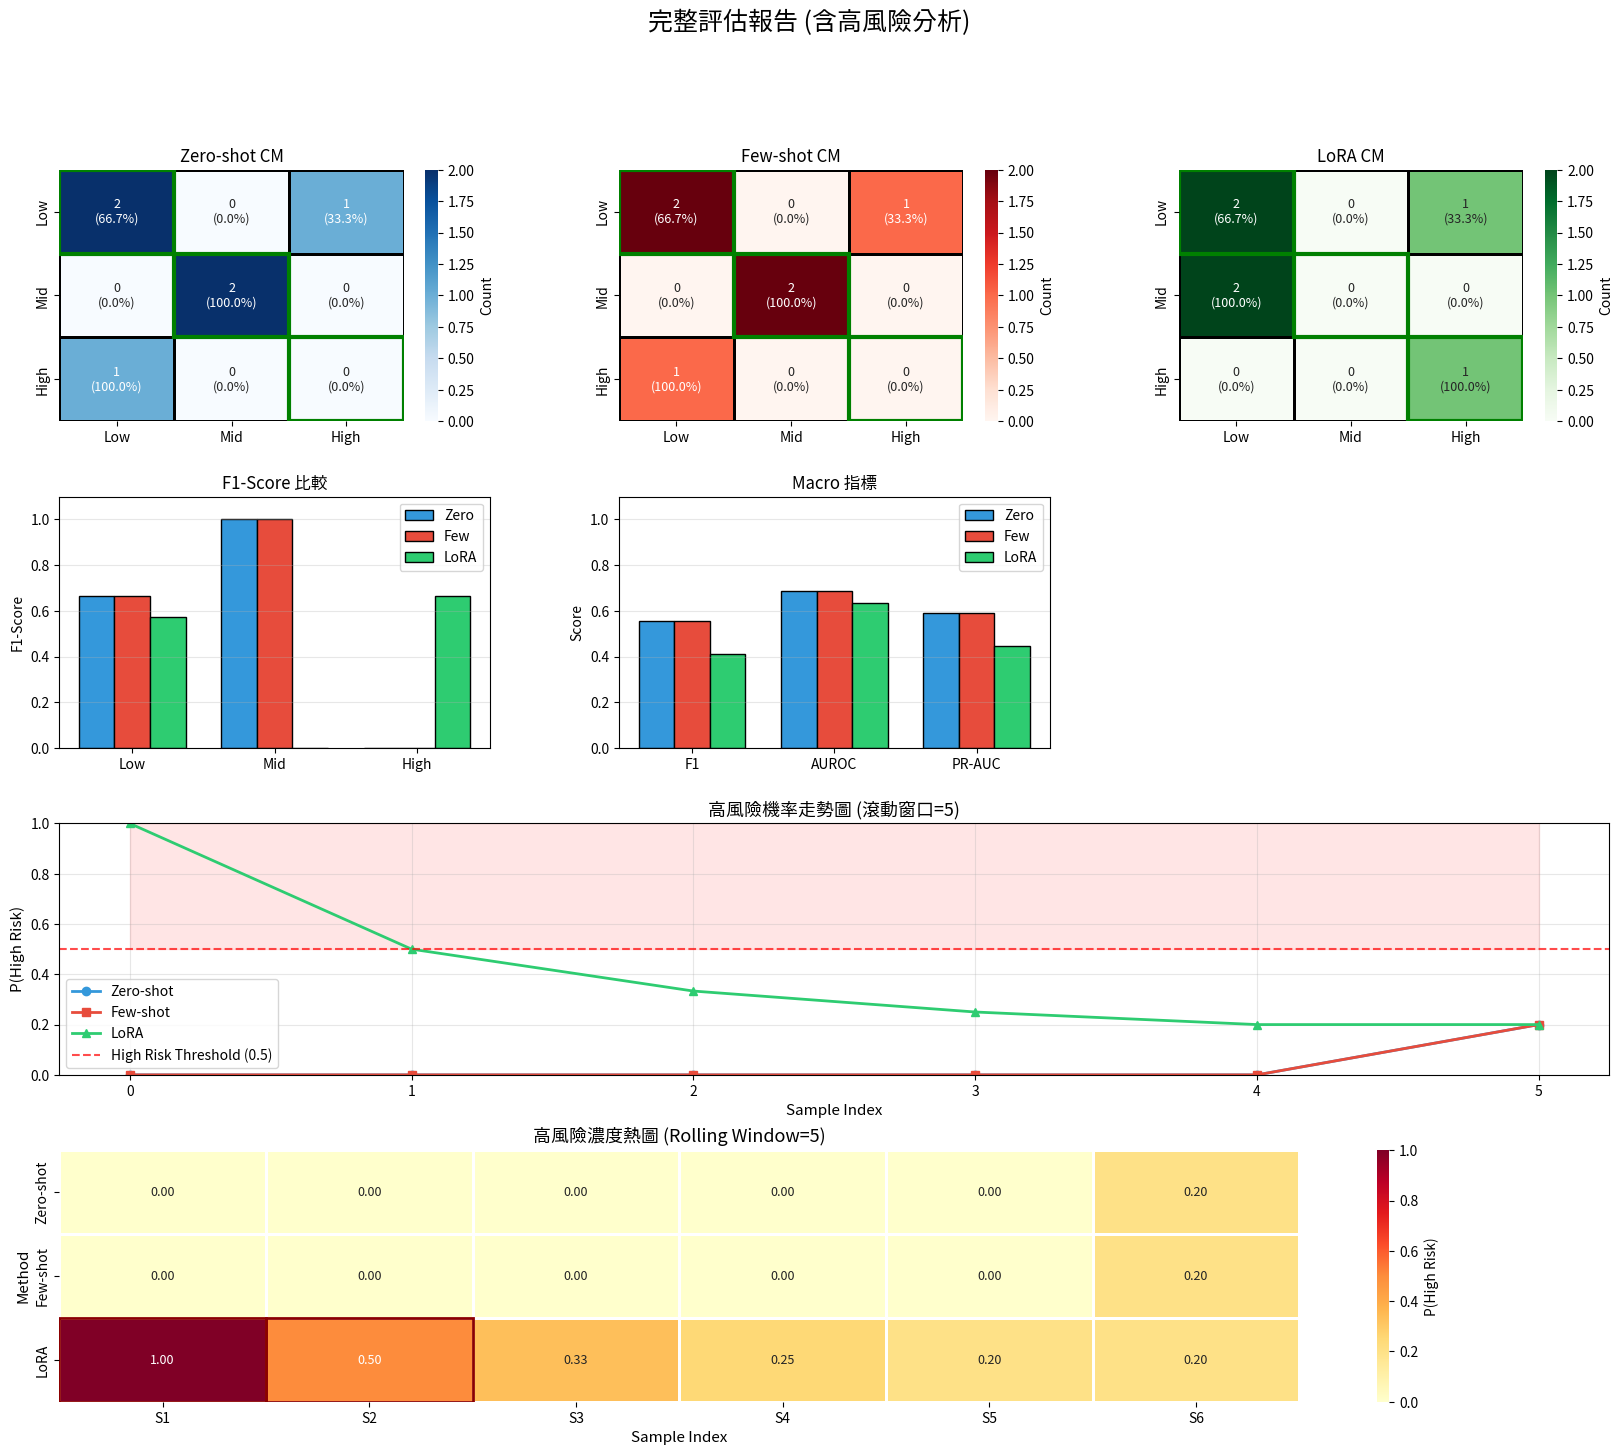


✅ 比較報告已保存

🎯 評估總結

【Zero-shot】
  F1-Macro:  0.5556
  F1-High:   0.0000 (憂鬱風險檢測)
  AUROC:     0.6889
  PR-AUC:    0.5926

【Few-shot】
  F1-Macro:  0.5556
  F1-High:   0.0000 (憂鬱風險檢測)
  AUROC:     0.6889
  PR-AUC:    0.5926

【LoRA】
  F1-Macro:  0.4127
  F1-High:   0.6667 (憂鬱風險檢測)
  AUROC:     0.6333
  PR-AUC:    0.4444


In [ ]:
# ====================================================
# Zero-shot vs Few-shot vs LoRA 三方評估比較 (含高風險分析)
# ====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')


def evaluate_model(results: list, model_name: str = "Model"):
    """
    計算核心評估指標: F1, AUROC, PR-AUC, Confusion Matrix
    """
    # 確保結果包含 risk_code
    for r in results:
        if 'true_risk_code' not in r:
            r['true_risk_code'] = map_risk_from_emotion(r['true_emotion'])[0]
        if 'pred_risk_code' not in r:
            r['pred_risk_code'] = map_risk_from_emotion(r['pred_emotion'])[0]

    # 過濾有效結果
    valid_results = [r for r in results if r['pred_risk_code'] != -1]

    if len(valid_results) == 0:
        print(f"❌ {model_name}: 沒有有效預測結果")
        return None, None, None

    # 提取標籤
    y_true = np.array([r['true_risk_code'] for r in valid_results])
    y_pred = np.array([r['pred_risk_code'] for r in valid_results])

    # 1. F1-Score
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    metrics = {
        'model_name': model_name,
        'f1_macro': f1_macro,
        'f1_low': f1_per_class[0] if len(f1_per_class) > 0 else 0,
        'f1_mid': f1_per_class[1] if len(f1_per_class) > 1 else 0,
        'f1_high': f1_per_class[2] if len(f1_per_class) > 2 else 0,
    }

    # 2. AUROC & PR-AUC
    if len(np.unique(y_true)) > 1:
        try:
            y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
            y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

            auroc_scores = []
            pr_auc_scores = []

            for i in range(3):
                if i in y_true:
                    auroc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
                    pr_auc = average_precision_score(y_true_bin[:, i], y_pred_bin[:, i])
                    auroc_scores.append(auroc)
                    pr_auc_scores.append(pr_auc)

            metrics['auroc_macro'] = np.mean(auroc_scores) if auroc_scores else 0
            metrics['pr_auc_macro'] = np.mean(pr_auc_scores) if pr_auc_scores else 0
        except:
            metrics['auroc_macro'] = 0
            metrics['pr_auc_macro'] = 0
    else:
        metrics['auroc_macro'] = 0
        metrics['pr_auc_macro'] = 0

    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    metrics['confusion_matrix'] = cm

    return metrics, y_true, y_pred


def compute_high_risk_probability(results: list, window_size: int = 10):
    """
    計算高風險機率 (用於走勢圖和熱圖)

    Args:
        results: 預測結果列表
        window_size: 滾動窗口大小

    Returns:
        high_risk_probs: 高風險機率序列
        rolling_probs: 滾動窗口機率
    """
    # 提取預測的風險等級
    pred_risks = [r['pred_risk_code'] for r in results]

    # 計算高風險機率 (pred_risk_code == 2)
    high_risk_probs = [1 if risk == 2 else 0 for risk in pred_risks]

    # 計算滾動窗口平均
    rolling_probs = []
    for i in range(len(high_risk_probs)):
        start_idx = max(0, i - window_size + 1)
        window = high_risk_probs[start_idx:i+1]
        rolling_probs.append(sum(window) / len(window))

    return high_risk_probs, rolling_probs


# ====================================================
# 評估三種方法
# ====================================================
print("\n" + "="*80)
print("📊 Zero-shot vs Few-shot vs LoRA 三方評估")
print("="*80)

# 評估 Zero-shot
zero_metrics, zero_y_true, zero_y_pred = evaluate_model(zero_results, "Zero-shot")

# 評估 Few-shot
few_metrics, few_y_true, few_y_pred = evaluate_model(few_results, "Few-shot")

# 評估 LoRA (如果存在)
if 'lora_results' in globals():
    lora_metrics, lora_y_true, lora_y_pred = evaluate_model(lora_results, "LoRA")
else:
    print("⚠️  LoRA 結果未找到")
    lora_metrics = None

has_lora = lora_metrics is not None
all_valid = zero_metrics and few_metrics

if not all_valid:
    print("❌ 評估失敗")
else:
    # ====================================================
    # 比較表格 (與之前相同)
    # ====================================================
    print("\n" + "="*80)
    print("📋 評估指標比較")
    print("="*80)

    table_data = {
        '指標': [
            'F1-Score (Macro)',
            'F1 - Low Risk',
            'F1 - Mid Risk',
            'F1 - High Risk ⭐',
            'AUROC (Macro)',
            'PR-AUC (Macro)'
        ],
        'Zero-shot': [
            f"{zero_metrics['f1_macro']:.4f}",
            f"{zero_metrics['f1_low']:.4f}",
            f"{zero_metrics['f1_mid']:.4f}",
            f"{zero_metrics['f1_high']:.4f}",
            f"{zero_metrics.get('auroc_macro', 0):.4f}",
            f"{zero_metrics.get('pr_auc_macro', 0):.4f}"
        ],
        'Few-shot': [
            f"{few_metrics['f1_macro']:.4f}",
            f"{few_metrics['f1_low']:.4f}",
            f"{few_metrics['f1_mid']:.4f}",
            f"{few_metrics['f1_high']:.4f}",
            f"{few_metrics.get('auroc_macro', 0):.4f}",
            f"{few_metrics.get('pr_auc_macro', 0):.4f}"
        ]
    }

    if has_lora:
        table_data['LoRA'] = [
            f"{lora_metrics['f1_macro']:.4f}",
            f"{lora_metrics['f1_low']:.4f}",
            f"{lora_metrics['f1_mid']:.4f}",
            f"{lora_metrics['f1_high']:.4f}",
            f"{lora_metrics.get('auroc_macro', 0):.4f}",
            f"{lora_metrics.get('pr_auc_macro', 0):.4f}"
        ]

    comparison_df = pd.DataFrame(table_data)

    # 判斷最佳
    comparison_df['最佳'] = ''
    for i in range(len(comparison_df)):
        vals = [float(comparison_df.iloc[i]['Zero-shot']),
                float(comparison_df.iloc[i]['Few-shot'])]
        names = ['Zero', 'Few']

        if has_lora:
            vals.append(float(comparison_df.iloc[i]['LoRA']))
            names.append('LoRA')

        max_val = max(vals)
        max_idx = vals.index(max_val)
        comparison_df.at[i, '最佳'] = f'✅ {names[max_idx]}'

    display(comparison_df)


    # ====================================================
    # 🆕 高風險分析 - 計算機率
    # ====================================================
    print("\n" + "="*80)
    print("🔴 高風險分析")
    print("="*80)

    # 使用更大的測試集 (如果可用)
    # 如果只有 6 個樣本,我們可以用整個 test set
    if len(zero_results) <= 10:
        print("⚠️  樣本數較少,建議使用完整測試集進行高風險分析")
        print("   以下使用現有樣本進行示範\n")

    # 計算高風險機率
    window_size = 5  # 滾動窗口大小

    zero_hr_prob, zero_rolling = compute_high_risk_probability(zero_results, window_size)
    few_hr_prob, few_rolling = compute_high_risk_probability(few_results, window_size)

    if has_lora:
        lora_hr_prob, lora_rolling = compute_high_risk_probability(lora_results, window_size)


    # ====================================================
    # 🆕 視覺化 - 包含高風險分析
    # ====================================================
    if has_lora:
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    else:
        fig = plt.figure(figsize=(16, 16))
        gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

    fig.suptitle('完整評估報告 (含高風險分析)', fontsize=18, fontweight='bold')

    # ===== Row 1: Confusion Matrices =====
    # Zero-shot CM
    ax1 = fig.add_subplot(gs[0, 0])
    cm_zero = zero_metrics['confusion_matrix']
    cm_zero_pct = cm_zero.astype('float') / cm_zero.sum(axis=1)[:, np.newaxis] * 100
    annotations_zero = np.empty_like(cm_zero, dtype=object)
    for i in range(cm_zero.shape[0]):
        for j in range(cm_zero.shape[1]):
            annotations_zero[i, j] = f'{cm_zero[i, j]}\n({cm_zero_pct[i, j]:.1f}%)'

    sns.heatmap(cm_zero, annot=annotations_zero, fmt='', cmap='Blues',
               xticklabels=['Low', 'Mid', 'High'],
               yticklabels=['Low', 'Mid', 'High'],
               ax=ax1, cbar_kws={'label': 'Count'},
               linewidths=2, linecolor='black',
               annot_kws={'size': 9, 'weight': 'bold'})
    ax1.set_title('Zero-shot CM', fontsize=12, fontweight='bold')
    for i in range(3):
        ax1.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', lw=3))

    # Few-shot CM
    ax2 = fig.add_subplot(gs[0, 1])
    cm_few = few_metrics['confusion_matrix']
    cm_few_pct = cm_few.astype('float') / cm_few.sum(axis=1)[:, np.newaxis] * 100
    annotations_few = np.empty_like(cm_few, dtype=object)
    for i in range(cm_few.shape[0]):
        for j in range(cm_few.shape[1]):
            annotations_few[i, j] = f'{cm_few[i, j]}\n({cm_few_pct[i, j]:.1f}%)'

    sns.heatmap(cm_few, annot=annotations_few, fmt='', cmap='Reds',
               xticklabels=['Low', 'Mid', 'High'],
               yticklabels=['Low', 'Mid', 'High'],
               ax=ax2, cbar_kws={'label': 'Count'},
               linewidths=2, linecolor='black',
               annot_kws={'size': 9, 'weight': 'bold'})
    ax2.set_title('Few-shot CM', fontsize=12, fontweight='bold')
    for i in range(3):
        ax2.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', lw=3))

    # LoRA CM (if exists)
    if has_lora:
        ax3 = fig.add_subplot(gs[0, 2])
        cm_lora = lora_metrics['confusion_matrix']
        cm_lora_pct = cm_lora.astype('float') / cm_lora.sum(axis=1)[:, np.newaxis] * 100
        annotations_lora = np.empty_like(cm_lora, dtype=object)
        for i in range(cm_lora.shape[0]):
            for j in range(cm_lora.shape[1]):
                annotations_lora[i, j] = f'{cm_lora[i, j]}\n({cm_lora_pct[i, j]:.1f}%)'

        sns.heatmap(cm_lora, annot=annotations_lora, fmt='', cmap='Greens',
                   xticklabels=['Low', 'Mid', 'High'],
                   yticklabels=['Low', 'Mid', 'High'],
                   ax=ax3, cbar_kws={'label': 'Count'},
                   linewidths=2, linecolor='black',
                   annot_kws={'size': 9, 'weight': 'bold'})
        ax3.set_title('LoRA CM', fontsize=12, fontweight='bold')
        for i in range(3):
            ax3.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', lw=3))


    # ===== Row 2: F1-Score & Macro Metrics =====
    # F1-Score 比較
    ax4 = fig.add_subplot(gs[1, 0])
    risk_levels = ['Low', 'Mid', 'High']
    zero_f1 = [zero_metrics['f1_low'], zero_metrics['f1_mid'], zero_metrics['f1_high']]
    few_f1 = [few_metrics['f1_low'], few_metrics['f1_mid'], few_metrics['f1_high']]

    x = np.arange(len(risk_levels))
    width = 0.25 if has_lora else 0.35

    bars1 = ax4.bar(x - width, zero_f1, width, label='Zero', color='#3498db', edgecolor='black')
    bars2 = ax4.bar(x, few_f1, width, label='Few', color='#e74c3c', edgecolor='black')

    if has_lora:
        lora_f1 = [lora_metrics['f1_low'], lora_metrics['f1_mid'], lora_metrics['f1_high']]
        bars3 = ax4.bar(x + width, lora_f1, width, label='LoRA', color='#2ecc71', edgecolor='black')

    ax4.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
    ax4.set_title('F1-Score 比較', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(risk_levels)
    ax4.legend()
    ax4.set_ylim(0, 1.1)
    ax4.grid(axis='y', alpha=0.3)

    # Macro Metrics 比較
    ax5 = fig.add_subplot(gs[1, 1])
    metrics_names = ['F1', 'AUROC', 'PR-AUC']
    zero_vals = [zero_metrics['f1_macro'], zero_metrics.get('auroc_macro', 0), zero_metrics.get('pr_auc_macro', 0)]
    few_vals = [few_metrics['f1_macro'], few_metrics.get('auroc_macro', 0), few_metrics.get('pr_auc_macro', 0)]

    x = np.arange(len(metrics_names))
    bars1 = ax5.bar(x - width, zero_vals, width, label='Zero', color='#3498db', edgecolor='black')
    bars2 = ax5.bar(x, few_vals, width, label='Few', color='#e74c3c', edgecolor='black')

    if has_lora:
        lora_vals = [lora_metrics['f1_macro'], lora_metrics.get('auroc_macro', 0), lora_metrics.get('pr_auc_macro', 0)]
        bars3 = ax5.bar(x + width, lora_vals, width, label='LoRA', color='#2ecc71', edgecolor='black')

    ax5.set_ylabel('Score', fontsize=10, fontweight='bold')
    ax5.set_title('Macro 指標', fontsize=12, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics_names)
    ax5.legend()
    ax5.set_ylim(0, 1.1)
    ax5.grid(axis='y', alpha=0.3)


    # ===== 🆕 Row 3: 高風險走勢圖 =====
    if has_lora:
        ax6 = fig.add_subplot(gs[2, :])
    else:
        ax6 = fig.add_subplot(gs[2, :])

    indices = list(range(len(zero_results)))

    ax6.plot(indices, zero_rolling, 'o-', label='Zero-shot',
             color='#3498db', linewidth=2, markersize=6)
    ax6.plot(indices, few_rolling, 's-', label='Few-shot',
             color='#e74c3c', linewidth=2, markersize=6)

    if has_lora:
        ax6.plot(indices, lora_rolling, '^-', label='LoRA',
                 color='#2ecc71', linewidth=2, markersize=6)

    # 添加高風險閾值線
    ax6.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5,
                alpha=0.7, label='High Risk Threshold (0.5)')

    ax6.set_xlabel('Sample Index', fontsize=11, fontweight='bold')
    ax6.set_ylabel('P(High Risk)', fontsize=11, fontweight='bold')
    ax6.set_title(f'高風險機率走勢圖 (滾動窗口={window_size})',
                  fontsize=13, fontweight='bold')
    ax6.legend(loc='best', fontsize=10)
    ax6.grid(True, alpha=0.3)
    ax6.set_ylim(0, 1.0)

    # 填充高風險區域
    ax6.fill_between(indices, 0.5, 1.0, alpha=0.1, color='red', label='High Risk Zone')


    # ===== 🆕 Row 4: 高風險濃度熱圖 =====
    # 準備熱圖數據
    heatmap_data = []
    methods = []

    heatmap_data.append(zero_rolling)
    methods.append('Zero-shot')

    heatmap_data.append(few_rolling)
    methods.append('Few-shot')

    if has_lora:
        heatmap_data.append(lora_rolling)
        methods.append('LoRA')

    heatmap_array = np.array(heatmap_data)

    if has_lora:
        ax7 = fig.add_subplot(gs[3, :])
    else:
        ax7 = fig.add_subplot(gs[3, :])

    sns.heatmap(heatmap_array, annot=True, fmt='.2f', cmap='YlOrRd',
               xticklabels=[f'S{i+1}' for i in range(len(indices))],
               yticklabels=methods,
               ax=ax7, cbar_kws={'label': 'P(High Risk)'},
               linewidths=1, linecolor='white',
               annot_kws={'size': 9, 'weight': 'bold'},
               vmin=0, vmax=1)

    ax7.set_xlabel('Sample Index', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Method', fontsize=11, fontweight='bold')
    ax7.set_title(f'高風險濃度熱圖 (Rolling Window={window_size})',
                  fontsize=13, fontweight='bold')

    # 標註高風險區域
    for i in range(len(methods)):
        for j in range(len(indices)):
            if heatmap_array[i, j] >= 0.5:
                ax7.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                           edgecolor='darkred', lw=2))

    plt.savefig('complete_evaluation_with_risk_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


    # ====================================================
    # 保存報告
    # ====================================================
    comparison_df.to_csv('three_methods_comparison.csv', index=False, encoding='utf-8-sig')
    print("\n✅ 比較報告已保存")


    # ====================================================
    # 總結
    # ====================================================
    print("\n" + "="*80)
    print("🎯 評估總結")
    print("="*80)

    for method_name, method_metrics in [('Zero-shot', zero_metrics),
                                         ('Few-shot', few_metrics),
                                         ('LoRA', lora_metrics if has_lora else None)]:
        if method_metrics:
            print(f"\n【{method_name}】")
            print(f"  F1-Macro:  {method_metrics['f1_macro']:.4f}")
            print(f"  F1-High:   {method_metrics['f1_high']:.4f} (憂鬱風險檢測)")
            print(f"  AUROC:     {method_metrics.get('auroc_macro', 0):.4f}")
            print(f"  PR-AUC:    {method_metrics.get('pr_auc_macro', 0):.4f}")

